Sistema de Recomendação Por Imagens

In [10]:
# Instala as bibliotecas necessárias de forma silenciosa
!pip install tensorflow scikit-learn matplotlib pillow -q

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random



In [11]:
import kagglehub

# Baxando o dataset base do Kaggle
print("Baixando o dataset...")
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
print(f"Dataset baixado e disponível em: {path}")

# Define o caminho para a pasta que contém as imagens
dataset_folder = os.path.join(path, "images/")

# Verifica se a pasta de imagens existe
if not os.path.exists(dataset_folder):
    print(f"ERRO: A pasta de imagens não foi encontrada em '{dataset_folder}'")
else:
    print("Pasta de imagens encontrada com sucesso.")

Baixando o dataset...


100%|██████████| 565M/565M [00:07<00:00, 78.1MB/s]

Extracting files...


Dataset baixado e disponível em: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1
Pasta de imagens encontrada com sucesso.


In [12]:
# Transfer Learning
# Carrega o modelo VGG16 pré-treinado sem a camada de classificação final
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

print("Modelo VGG16 carregado com sucesso.")

# Função para extrair as características visuais de uma imagem
def extract_features(img_path, model):
    try:
        # Carrega e redimensiona a imagem
        img = load_img(img_path, target_size=(224, 224))
        # Converte para um array
        img_array = img_to_array(img)
        # Expande as dimensões para o formato que o modelo espera (1, 224, 224, 3)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        # Pré-processa a imagem
        preprocessed_img = preprocess_input(expanded_img_array)
        # Extrai as características
        features = model.predict(preprocessed_img, verbose=0)
        # Achata o resultado para um vetor unidimensional
        flattened_features = features.flatten()
        # Normaliza o vetor
        normalized_features = flattened_features / np.linalg.norm(flattened_features)
        return normalized_features
    except Exception as e:
        # Informa se houver erro ao processar alguma imagem
        print(f"Erro ao processar a imagem {img_path}: {e}")
        return None

Modelo VGG16 carregado com sucesso.


In [13]:
# Para um teste rápido, vamos usar apenas as primeiras 1000 imagens.
# Para o projeto completo, remova o [:1000].
image_files = [f for f in os.listdir(dataset_folder) if f.endswith('.jpg')][:1000]
all_features = []
valid_image_files = []

print(f"Iniciando extração de características de {len(image_files)} imagens...")

# Loop para processar cada imagem
for i, img_file in enumerate(image_files):
    full_path = os.path.join(dataset_folder, img_file)
    features = extract_features(full_path, model)
    if features is not None:
        all_features.append(features)
        valid_image_files.append(img_file)

    # Mostra o progresso a cada 100 imagens
    if (i + 1) % 100 == 0:
        print(f"Processado {i + 1}/{len(image_files)} imagens.")

# Converte a lista para um array NumPy
all_features_np = np.array(all_features)
print("Extração de características concluída!")

# Salva as características e os nomes dos arquivos para uso futuro
np.save('features.npy', all_features_np)
np.save('filenames.npy', valid_image_files)
print("Características e nomes de arquivos salvos com sucesso!")

Iniciando extração de características de 1000 imagens...
Processado 100/1000 imagens.
Processado 200/1000 imagens.
Processado 300/1000 imagens.
Processado 400/1000 imagens.
Processado 500/1000 imagens.
Processado 600/1000 imagens.
Processado 700/1000 imagens.
Processado 800/1000 imagens.
Processado 900/1000 imagens.
Processado 1000/1000 imagens.
Extração de características concluída!
Características e nomes de arquivos salvos com sucesso!


Carregando características e nomes de arquivos...
Imagem de referência escolhida: 6526.jpg
Gerando visualização das recomendações...


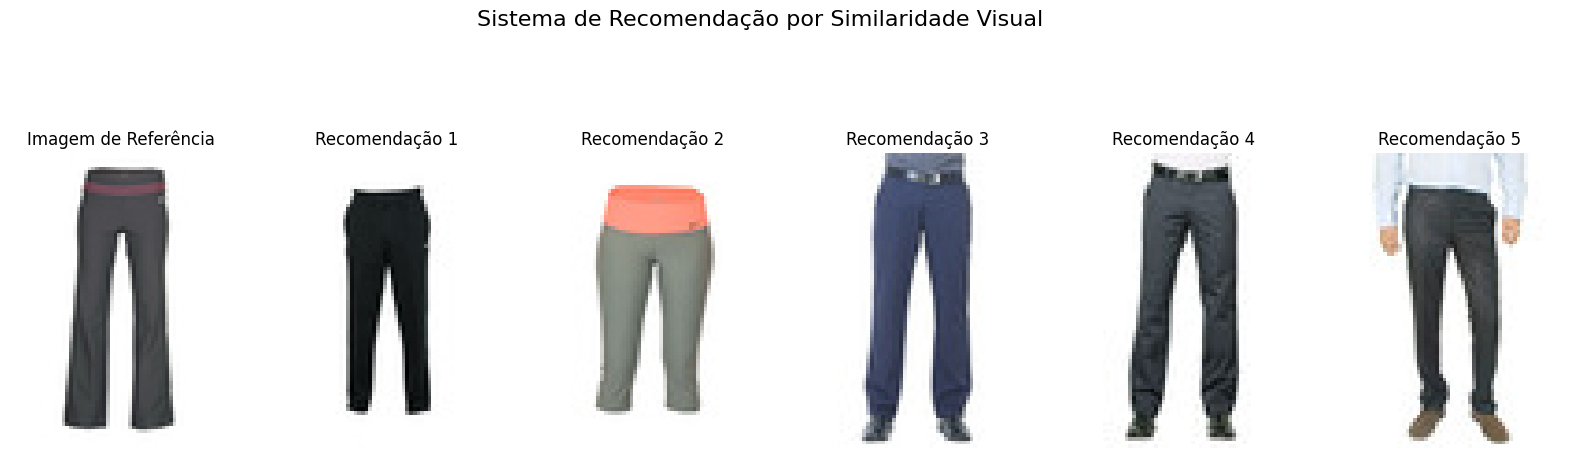

In [15]:
print("Carregando características e nomes de arquivos...")
# Carrega os vetores e nomes de arquivos que foram salvos
all_features = np.load('features.npy')
image_files = np.load('filenames.npy')

# Escolhe uma imagem aleatória como referência
reference_image_index = random.randint(0, len(image_files) - 1)
reference_features = all_features[reference_image_index].reshape(1, -1)
reference_image_path = os.path.join(dataset_folder, image_files[reference_image_index])

print(f"Imagem de referência escolhida: {image_files[reference_image_index]}")

# Calcula a similaridade de cosseno
similarities = cosine_similarity(reference_features, all_features)

# Obtém os índices das 5 imagens mais similares (excluindo a própria imagem)
similar_indices = similarities[0].argsort()[-6:-1][::-1]

# Exibe os resultados
print("Gerando visualização das recomendações...")
plt.figure(figsize=(20, 6))

# Imagem de Referência
plt.subplot(1, 6, 1)
plt.title("Imagem de Referência")
img_ref = mpimg.imread(reference_image_path)
plt.imshow(img_ref)
plt.axis('off')

# Imagens Recomendadas
for i, index in enumerate(similar_indices):
    plt.subplot(1, 6, i + 2)
    plt.title(f"Recomendação {i+1}")
    img_path = os.path.join(dataset_folder, image_files[index])
    img_rec = mpimg.imread(img_path)
    plt.imshow(img_rec)
    plt.axis('off')

plt.suptitle("Sistema de Recomendação por Similaridade Visual", fontsize=16)
plt.show()